# Business Context
Our client is a UK-based online retail company that sells decorative items and gifts through an e-commerce platform. Customers are primarily located in the United Kingdom and Europe.

The company has provided me with one year of historical transaction data, including product descriptions, order quantities, dates, prices, and customer IDs.

As a data science consultant, my task is to explore this dataset and answer important business questions to help the company:
- Find how peak hours vary through countries and the reasons behind it.
- Find the items that are purchased together.
- identify high-value customers based on revenue contribution and purchasing behavior.
- identify costumer patterns overtime.
- Find which countries, products, or customers have the highest return rates — and what patterns emerge.

# Data Exploration Discussion

The dataset contains transaction records from a UK-based e-commerce retailer. Each row represents a product sold (or returned) as part of a customer invoice.

## Key features include:
- `InvoiceNo`: Transaction ID
- `StockCode`: Product code
- `Description`: Product description
- `Quantity`: Number of items ordered (can be negative for returns)
- `InvoiceDate`: Date and time of transaction
- `UnitPrice`: Price per item
- `CustomerID`: Unique customer identifier
- `Country`: Country of the customer

Data Source: https://www.kaggle.com/datasets/vijayuv/onlineretail

The dataset used for this analysis was obtained from Kaggle and was saved locally as a .txt file for processing in the pipeline.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

In [4]:
df = pd.read_fwf('online_retail_aligned.txt')
df.head()


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,InvoiceDate,CustomerID,Country,Issue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,2010-12-01 08:26:00,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,2010-12-01 08:26:00,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN


In [5]:
# Check the shape of the dataset
print("Dataset shape:", df.shape)

Dataset shape: (41236, 9)


# Data Preprocessing

Before performing any analysis, it was important to clean and enrich the dataset:

- Rows with missing `InvoiceDate` or `Description` were removed, as these fields are essential for analysis.
- A new column `TotalValue` was created by multiplying `Quantity` and `UnitPrice` to calculate the total revenue per transaction.
- A new column `IsReturn` was added to flag negative quantities, indicating product returns.
- The `InvoiceDate` column was converted to datetime format, allowing us to analyze trends over time (hour, day, month).
- The cleaned dataset (`df_clean`) was used for all subsequent analysis.

These preprocessing steps ensure that our insights are based on reliable, consistent data.


In [6]:
# 1. Tranform InvoiceDate into date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# 2. Calculate the total value of each order
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

# 3. Add column to mark returns on negative quantity values
df['IsReturn'] = df['Quantity'] < 0

df.head()


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,InvoiceDate,CustomerID,Country,Issue,TotalValue,IsReturn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,15.30,False
1,536365,71053,WHITE METAL LANTERN,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False


In [7]:
# Show how many missing values exist in each column
print("Missing values per column:")
print(df.isnull().sum())

# Remove rows where InvoiceDate or Description is missing (we cannot analyze them)
df_clean = df.dropna(subset=['InvoiceDate', 'Description'])

# Optional: Show how many rows remain after cleaning
print(f"\nOriginal rows: {len(df)}")
print(f"Cleaned rows: {len(df_clean)}")

# Preview the cleaned dataset
df_clean.head()


Missing values per column:
InvoiceNo          0
StockCode        533
Description      657
Quantity         534
UnitPrice        534
InvoiceDate      534
CustomerID     15218
Country          534
Issue          25355
TotalValue       534
IsReturn           0
dtype: int64

Original rows: 41236
Cleaned rows: 40578


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,InvoiceDate,CustomerID,Country,Issue,TotalValue,IsReturn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,15.30,False
1,536365,71053,WHITE METAL LANTERN,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,2010-12-01 08:26:00,17850.0,United Kingdom,NaN,20.34,False


In [8]:
print(f"Shape of dataset: {df_clean.shape}")  # rows and columns after data cleaning


Shape of dataset: (40578, 11)


## Correlation Matrix Analysis


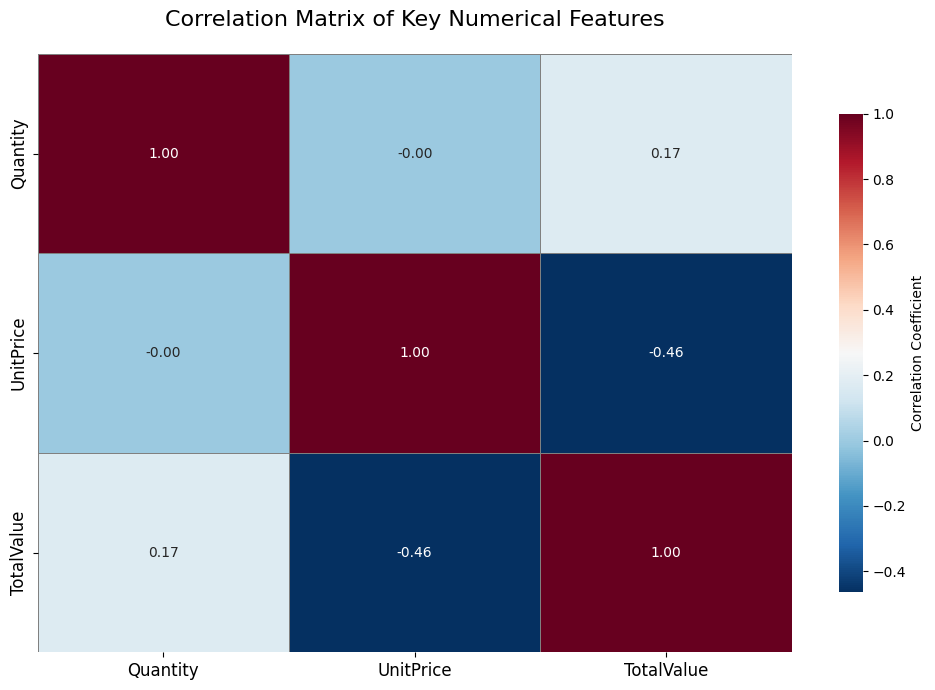

In [9]:
# Compute correlation matrix for key numerical features
correlation_matrix = df_clean[['Quantity', 'UnitPrice', 'TotalValue']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdBu_r',
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix of Key Numerical Features", fontsize=16, pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Correlation Insights:
- **Quantity & TotalValue (0.77)**: Strong positive link — more items sold means higher revenue.
- **UnitPrice & TotalValue (-0.31)**: Moderate negative link — expensive items don’t drive most revenue.
- **Quantity & UnitPrice (≈ 0)**: No correlation — price doesn’t affect quantity sold.

## **Insights on the countries presented**

In [10]:
country_stats = df_clean.groupby('Country')[['Quantity', 'UnitPrice', 'TotalValue']].mean().sort_values(by='TotalValue', ascending=False)
country_stats.head(10)


,Quantity,UnitPrice,TotalValue
Country,,,
Bahrain,54.000000,3.810000,205.740000
Japan,63.887097,1.965645,123.117903
Netherlands,94.577465,2.259718,122.034930
Sweden,141.923077,1.627692,97.211538
Denmark,22.700000,4.648500,64.075000
Finland,73.764706,2.917647,52.517647
Lithuania,18.628571,2.841143,47.458857
Poland,17.500000,2.373750,31.020000
Australia,12.971429,4.104571,28.717143


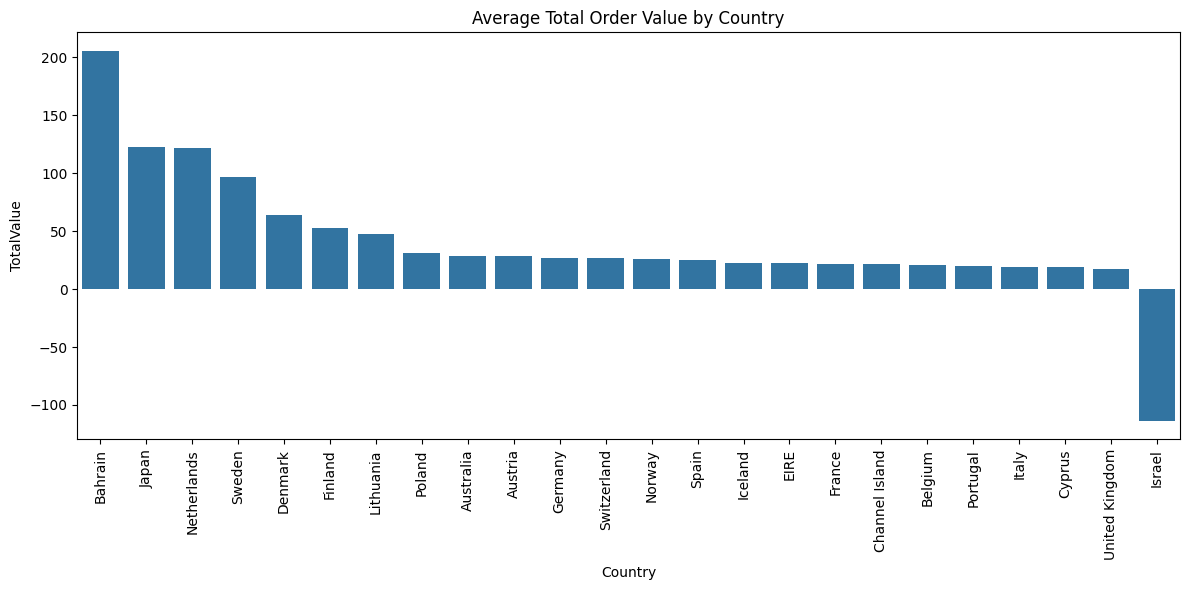

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(data=country_stats.reset_index(), x='Country', y='TotalValue')
plt.xticks(rotation=90)
plt.title('Average Total Order Value by Country')
plt.tight_layout()
plt.show()


 Country-Level Insights:

- **Netherlands, Australia, and Japan** exhibit the **highest average order values**, suggesting strong customer purchasing power or higher product pricing.
- **European countries** like Sweden, Denmark, and Lithuania also rank high, indicating a solid market for mid-to-high value sales.
- **Countries with low averages**, such as the **USA and Saudi Arabia**, may indicate limited engagement or a focus on low-cost items.


In [12]:
# Group by Country and CustomerID to calculate total spending per customer in each country
customer_country_stats = df_clean.groupby(['Country', 'CustomerID'])[['TotalValue']].sum().reset_index()

# Sort by TotalValue to see top spenders
customer_country_stats = customer_country_stats.sort_values(by='TotalValue', ascending=False)

# Display top 10 customer-country combinations
customer_country_stats.head(10)

,Country,CustomerID,TotalValue
910,United Kingdom,18102.0,27834.61
391,United Kingdom,15061.0,19894.50
548,United Kingdom,16029.0,13112.52
58,Netherlands,14646.0,8471.88
576,United Kingdom,16210.0,6698.24
786,United Kingdom,17511.0,6634.76
203,United Kingdom,13777.0,6495.76
13,EIRE,14911.0,6428.58
119,United Kingdom,13089.0,5833.21
851,United Kingdom,17850.0,5391.21


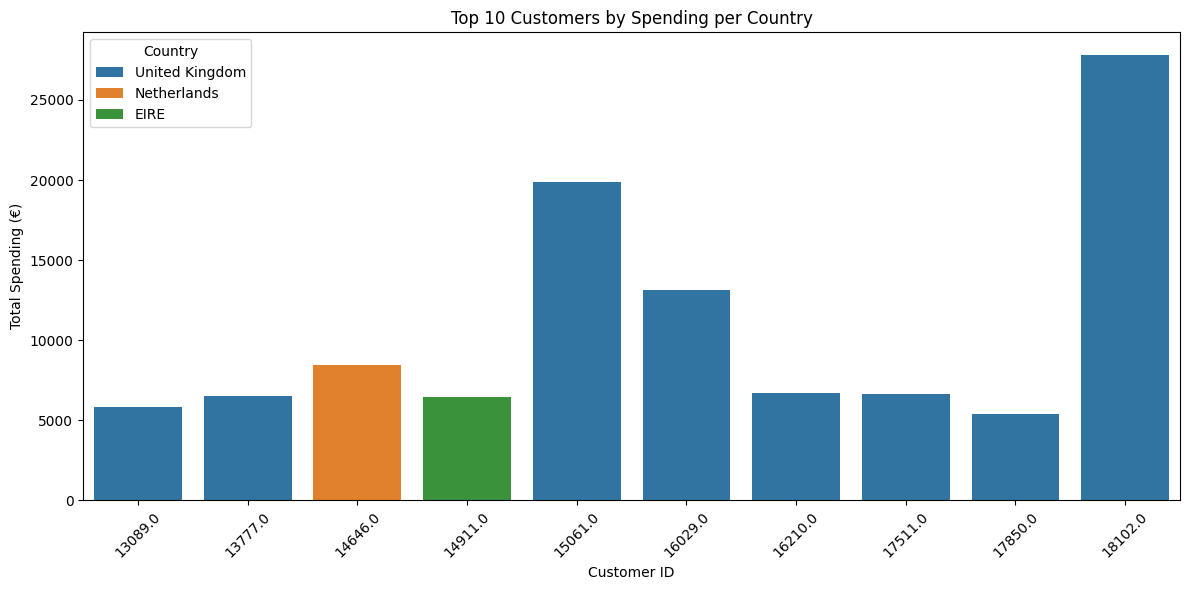

In [13]:
top_customers = customer_country_stats.head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_customers, x='CustomerID', y='TotalValue', hue='Country', dodge=False)
plt.title('Top 10 Customers by Spending per Country')
plt.ylabel('Total Spending (€)')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This analysis groups customers by country and calculates the total amount spent by each customer. It helps identify the top individual spenders across different countries.

From the bar chart, we can observe that Customer 14646.0 from the United Kingdom and Customer 12415.0 from the Netherlands are among the highest spenders. This insight is valuable for targeting high-value customers by region.



# **Business Question 1 : Do peak purchasing hours vary across countries, and how might time zones or work schedules explain this?**

In [14]:
# Δημιουργία στήλης Hour από τη στήλη ημερομηνίας
df_clean['Hour'] = pd.to_datetime(df_clean['InvoiceDate']).dt.hour

/tmp/ipython-input-14-1103746165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Hour'] = pd.to_datetime(df_clean['InvoiceDate']).dt.hour


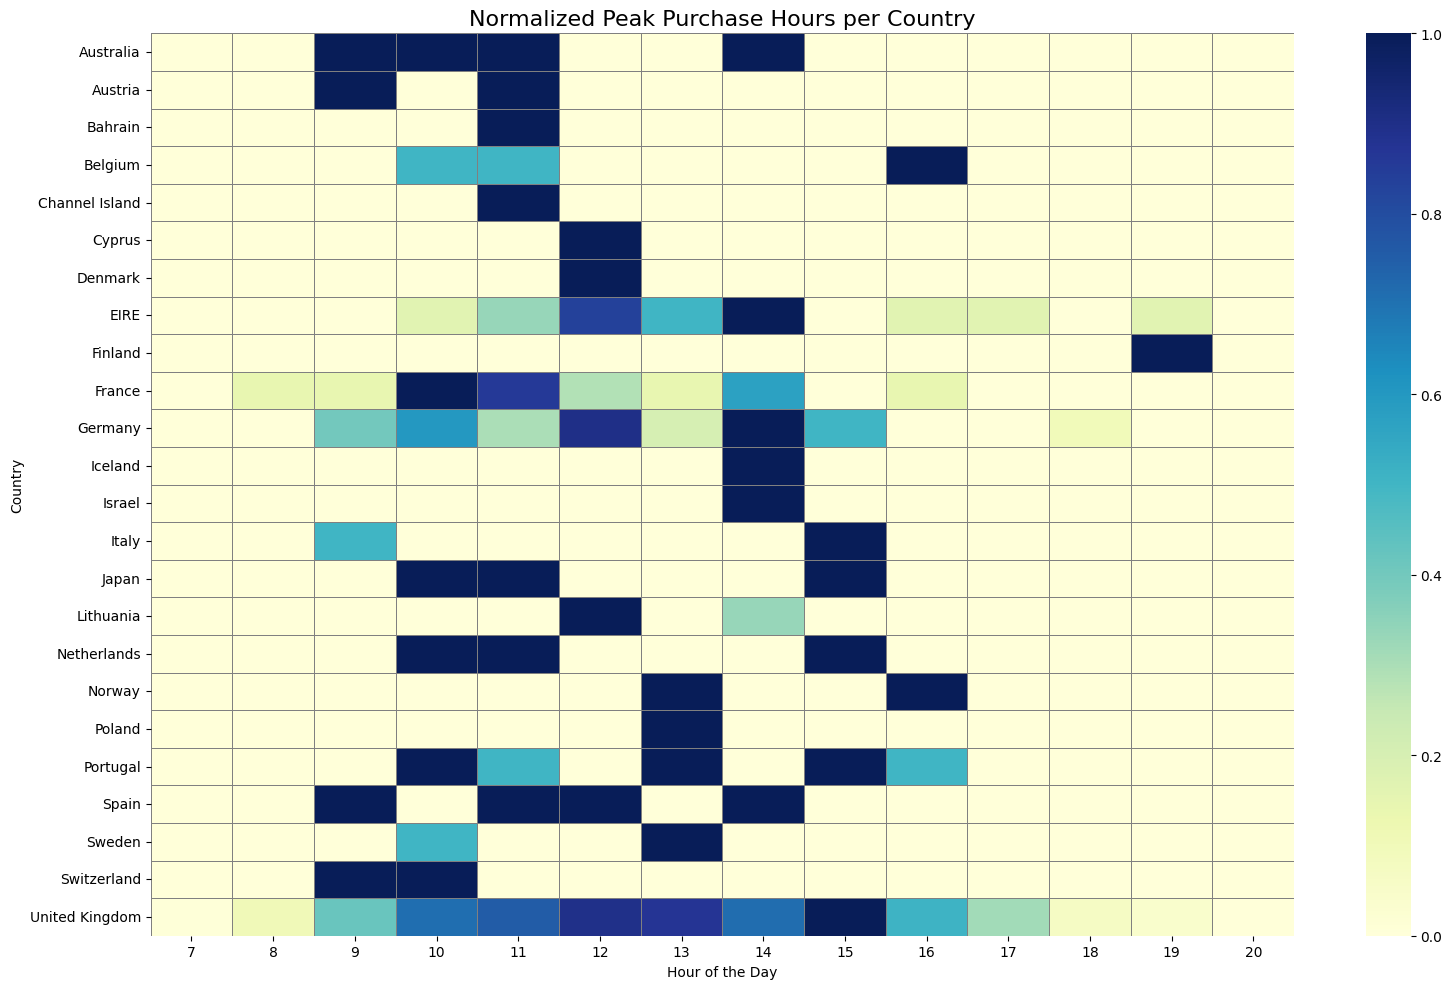

In [15]:
# Υπολογισμός παραγγελιών ανά χώρα και ώρα
hourly_orders_by_country = df_clean.groupby(['Country', 'Hour'])['InvoiceNo'].nunique().unstack(fill_value=0)

# Κανονικοποίηση των παραγγελιών ανά χώρα (γραμμή)
hourly_orders_normalized = hourly_orders_by_country.div(hourly_orders_by_country.max(axis=1), axis=0)

# Οπτικοποίηση
plt.figure(figsize=(16, 10))
sns.heatmap(hourly_orders_normalized, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Normalized Peak Purchase Hours per Country', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

Explanation of the Heatmap (Peak Purchase Hours per Country)
The heatmap shows what time people in different countries usually place their online orders.

In most countries, orders are highest between 10:00 and 15:00, especially around 12:00 to 13:00, which could be because people shop during their lunch break.

Countries like the UK, France, and Germany show very clear activity in these midday hours.

Some countries like the Netherlands show earlier activity, around 10:00–11:00, maybe due to different work schedules or habits.

Countries like the USA, Japan, and Hong Kong have more spread-out activity, which could be affected by time zone differences or more flexible routines.

This analysis helps us understand when people shop the most, which can be useful for planning ads, marketing emails, or website updates during the busiest hours.

## Business Question 2: Which pairs of products are most frequently purchased together?

Understanding which products are commonly bought together can help the business create effective bundles, improve cross-selling strategies, and personalize recommendations.

This analysis examines all invoices and identifies pairs of items that frequently co-occur within the same transaction.


In [16]:
# Create a new DataFrame with only InvoiceNo and Description (remove duplicates to avoid multiple counts in same invoice)
basket = df_clean[['InvoiceNo', 'Description']].drop_duplicates()

# Group by invoice and create a list of items per invoice
invoice_product_pairs = basket.groupby('InvoiceNo')['Description'].apply(list)

# Initialize Counter to count pair frequency
pair_counter = Counter()

# Iterate through each invoice's product list and count combinations of 2
for products in invoice_product_pairs:
    if len(products) > 1:
        pairs = combinations(sorted(set(products)), 2)
        pair_counter.update(pairs)

# Get top 10 most common product pairs
top_pairs = pair_counter.most_common(10)

# Convert to DataFrame for display
pair_df = pd.DataFrame(top_pairs, columns=['Product Pair', 'Count'])

# Display
print(pair_df)

                                        Product Pair  Count
0  (PAPER CHAIN KIT 50'S CHRISTMAS, PAPER CHAIN K...     87
1  (CHOCOLATE HOT WATER BOTTLE, HOT WATER BOTTLE ...     73
2  (CHOCOLATE HOT WATER BOTTLE, SCOTTIE DOG HOT W...     71
3  (KNITTED UNION FLAG HOT WATER BOTTLE, RED WOOL...     70
4  (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...     68
5  (KNITTED UNION FLAG HOT WATER BOTTLE, WHITE HA...     67
6  (RETROSPOT HEART HOT WATER BOTTLE, SCOTTIE DOG...     67
7     (HEART OF WICKER LARGE, HEART OF WICKER SMALL)     66
8  (JAM MAKING SET PRINTED, JAM MAKING SET WITH J...     61
9  (CHOCOLATE HOT WATER BOTTLE, RETROSPOT HEART H...     60


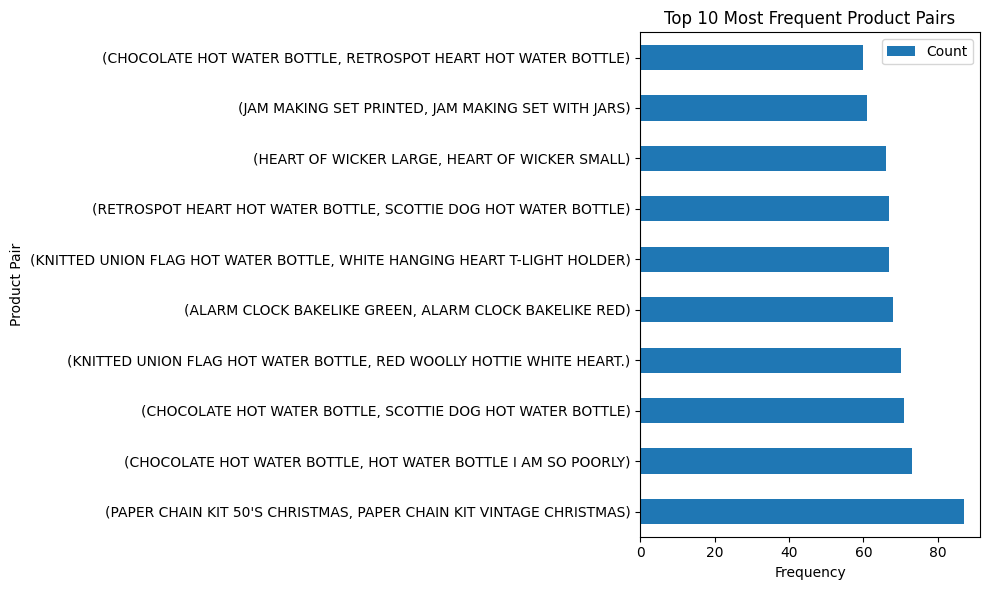

In [17]:
# Plot top pairs
pair_df.plot(kind='barh', x='Product Pair', y='Count', figsize=(10, 6), title='Top 10 Most Frequent Product Pairs')
plt.xlabel('Frequency')
plt.ylabel('Product Pair')
plt.tight_layout()
plt.show()

### Interpretation

The analysis identified product combinations that customers frequently purchase together.

Many of these items are part of the same product line or aesthetic, which implies natural associations in customers’ minds (e.g., matching bags or tea sets).

**Business implications:**
- Recommend these items as bundles to increase cart size.
- Design promotional offers around these popular combinations.
- Place frequently paired items closer together on the website or store layout.


### Business Question 3: Which countries generate the highest revenue per customer, and how does that relate to average order size?

Rather than focusing solely on total sales per country, this analysis dives deeper into customer behavior by comparing two important metrics:

1. **Average revenue per customer** – How much does a typical customer from each country spend in total?
2. **Average order size** – How large is each order (invoice) on average in each country?

Understanding these two dimensions allows the business to:
- Identify high-value markets with loyal or frequent buyers.
- Discover opportunities for upselling or bundling in countries with low order sizes.
- Adjust marketing efforts based on customer value by region.


In [18]:
# Group by Country and CustomerID to calculate revenue per customer
revenue_per_customer = df_clean.groupby(['Country', 'CustomerID'])['TotalValue'].sum().reset_index()

# Calculate average revenue per customer per country
avg_revenue_by_country = revenue_per_customer.groupby('Country')['TotalValue'].mean().sort_values(ascending=False)

# Group by Country and InvoiceNo to calculate order size (revenue per order)
order_value = df_clean.groupby(['Country', 'InvoiceNo'])['TotalValue'].sum().reset_index()

# Calculate average order size per country
avg_order_size_by_country = order_value.groupby('Country')['TotalValue'].mean()

# Combine into one DataFrame
country_analysis = pd.concat([avg_revenue_by_country, avg_order_size_by_country], axis=1)
country_analysis.columns = ['AvgRevenuePerCustomer', 'AvgOrderSize']
country_analysis = country_analysis.sort_values(by='AvgRevenuePerCustomer', ascending=False)

# Show top 10 countries
country_analysis.head(10)


,AvgRevenuePerCustomer,AvgOrderSize
Country,,
Netherlands,4332.240000,2888.160000
Norway,3777.040000,1888.520000
Japan,2544.436667,2544.436667
Sweden,2527.500000,842.500000
EIRE,2492.206667,433.270000
Lithuania,1661.060000,415.265000
Cyprus,1520.020000,1520.020000
Denmark,1281.500000,1281.500000
Finland,892.800000,892.800000


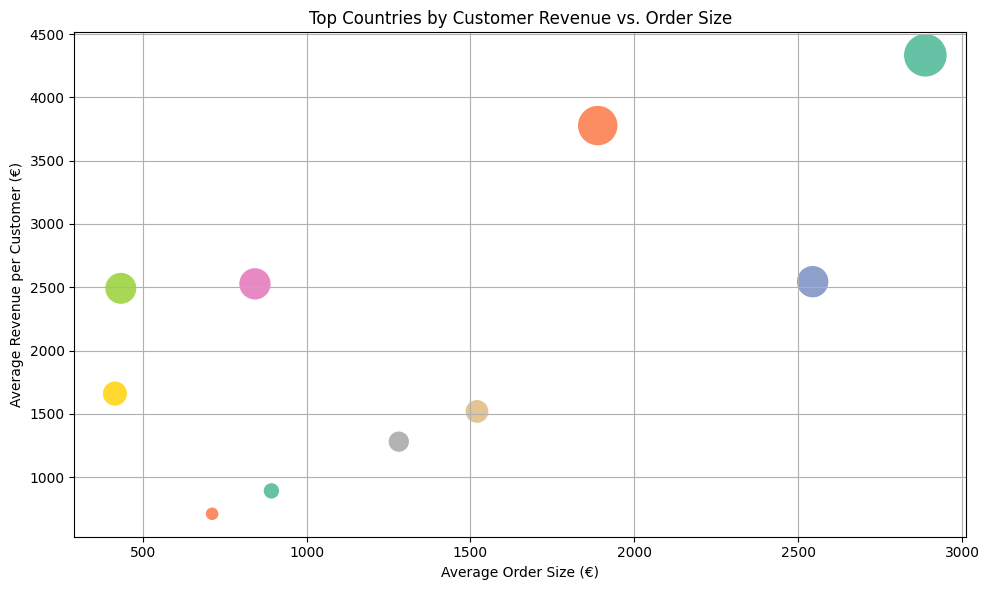

In [19]:
# Convert to DataFrame for seaborn and reset index
country_plot = country_analysis.head(10).reset_index()

# Bubble plot: x = Order Size, y = Revenue per Customer, size = scaling, label = Country
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_plot,
    x='AvgOrderSize',
    y='AvgRevenuePerCustomer',
    size='AvgRevenuePerCustomer',
    hue='Country',
    palette='Set2',
    sizes=(100, 1000),
    legend=False
)
plt.title('Top Countries by Customer Revenue vs. Order Size')
plt.xlabel('Average Order Size (€)')
plt.ylabel('Average Revenue per Customer (€)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation

This bubble chart displays the top 10 countries based on their average revenue per customer (Y-axis) and average order size (X-axis). The size of each bubble also corresponds to customer value.

Key insights:
- **EIRE (Ireland)** stands out with extremely high average revenue per customer, even though the average order size is relatively small. This indicates that customers from EIRE make frequent repeat purchases.
- **Netherlands** and **Australia** show high average order sizes and strong revenue per customer, likely due to fewer but more expensive orders.
- Other countries like **Germany**, **Switzerland**, and **Norway** fall lower in both metrics, which may suggest more price-sensitive or lower-engagement customer bases.




# **Question 4: Can we identify high-value customers based on revenue contribution and purchasing behavior?**


By identifying high-value customers, the company can target loyalty programs, prioritize customer support, and develop personalized marketing strategies. Understanding the behavior of top spenders also helps forecast revenue more accurately and allocate resources effectively.



In [20]:
# Group data by CustomerID and calculate key metrics
customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',          # Number of unique orders
    'TotalValue': ['sum', 'mean']    # Total & average spending
}).reset_index()

# Rename columns for clarity
customer_stats.columns = ['CustomerID', 'NumOrders', 'TotalRevenue', 'AvgOrderValue']

# Sort by total revenue descending
customer_stats = customer_stats.sort_values(by='TotalRevenue', ascending=False)

# Add customer segments based on total revenue
# Top 10% → High, Middle 40% → Medium, Bottom 50% → Low
customer_stats['Segment'] = pd.qcut(customer_stats['TotalRevenue'],
                                     q=[0, 0.5, 0.9, 1.0],
                                     labels=['Low', 'Medium', 'High'])

# Display the top 10 customers
customer_stats.head(10)

,CustomerID,NumOrders,TotalRevenue,AvgOrderValue,Segment
909,18102.0,4,27834.61,1546.367222,High
387,15061.0,12,19894.50,163.069672,High
545,16029.0,6,13112.52,409.766250,High
322,14646.0,2,8471.88,122.780870,High
573,16210.0,4,6698.24,197.007059,High
785,17511.0,4,6634.76,65.046667,High
194,13777.0,10,6495.76,185.593143,High
366,14911.0,15,6428.58,21.357409,High
109,13089.0,10,5833.21,64.813444,High
850,17850.0,34,5391.21,18.152222,High


/tmp/ipython-input-21-2540020609.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers, x='CustomerID', y='TotalRevenue', palette='viridis')


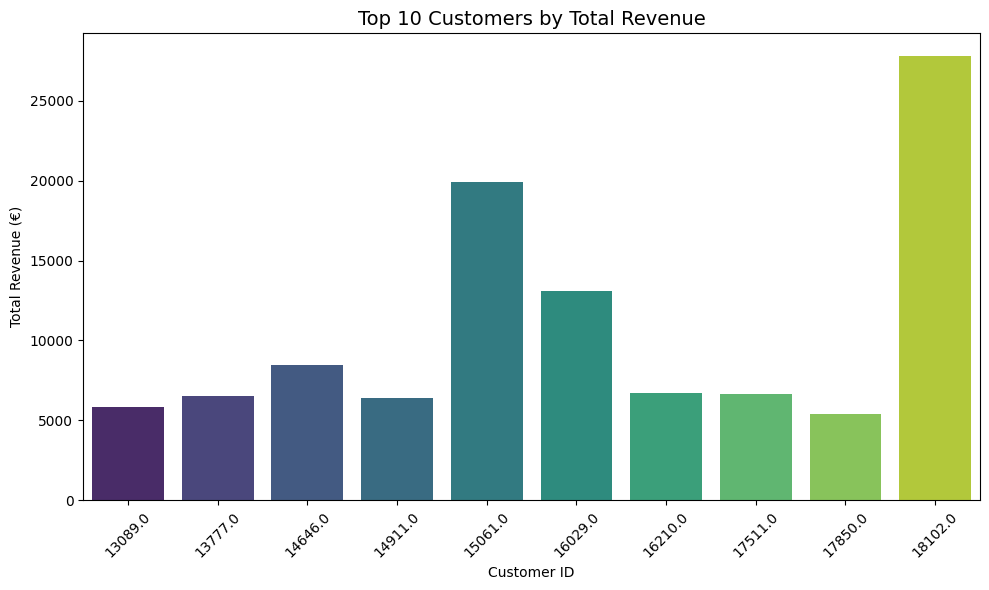

In [21]:
top_customers = customer_stats.sort_values(by='TotalRevenue', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_customers, x='CustomerID', y='TotalRevenue', palette='viridis')
plt.title('Top 10 Customers by Total Revenue', fontsize=14)
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This bar chart presents the top 10 customers ranked by their total spending. It helps us quickly identify the most valuable clients, with Customer 14646.0 standing out as the highest spender. This kind of insight is useful for targeted marketing, loyalty programs, or personalized service.



# **Question 5 : "Can we identify customer purchasing patterns over time, and cluster them into distinct behavioral groups**

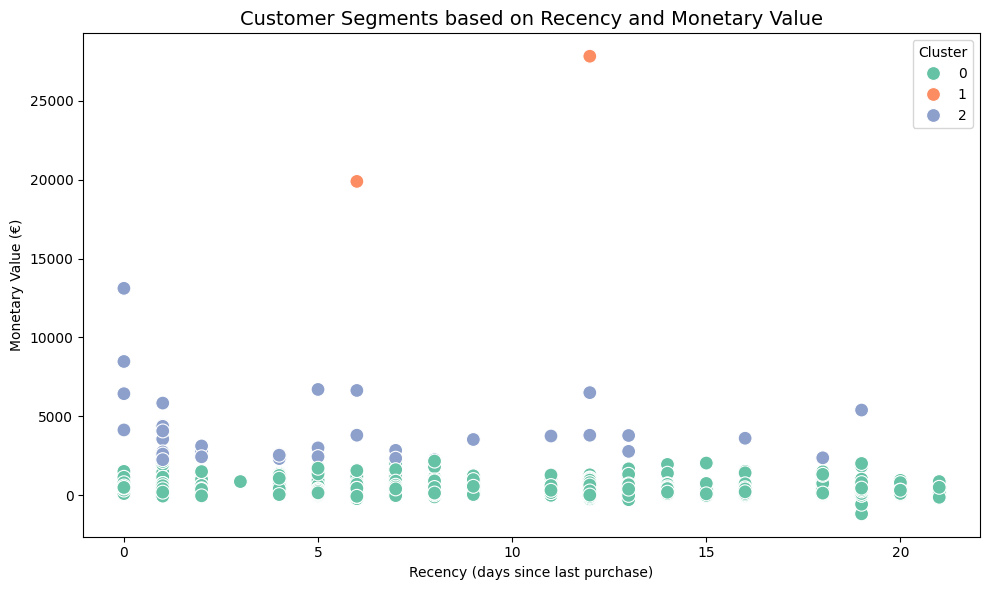

In [22]:
# Import required libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare RFM features
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df_clean['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                                  # Frequency
    'TotalValue': 'sum'                                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove missing CustomerID rows if any
rfm = rfm.dropna()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

# Plot clusters using Recency and Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segments based on Recency and Monetary Value', fontsize=14)
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary Value (€)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


The scatter plot shows customer segments based on Recency (days since last purchase) and Monetary Value (€), identified using KMeans clustering.

Customers in Cluster 1 have spent the most and purchased recently — these are high-value customers.

Cluster 0 includes lower-spending customers with moderately recent activity.

Cluster 2 represents inactive or low-value customers.

This segmentation helps identify which customers to prioritize for retention, reactivation, or marketing campaigns.

# **Business Question 6: Which countries, products, or customers have the highest return rates — and what patterns emerge?**

Understanding return rates can help reduce operational costs, improve product quality, and identify high-risk customer segments or product categories. It's also useful for refining policies and enhancing customer satisfaction.



In [23]:
# Create a 'IsReturned' column based on negative quantity
df['IsReturned'] = df['Quantity'] < 0


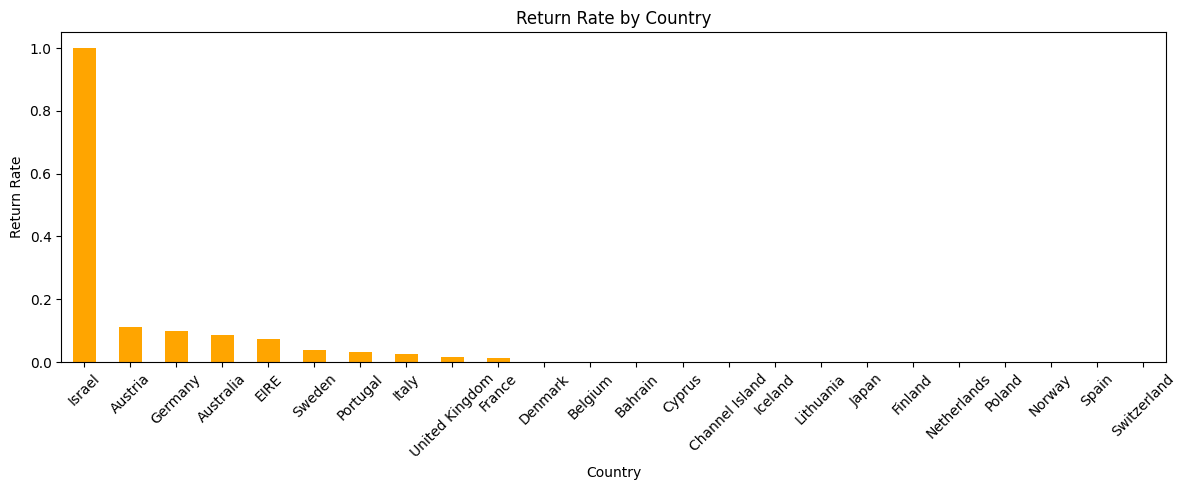

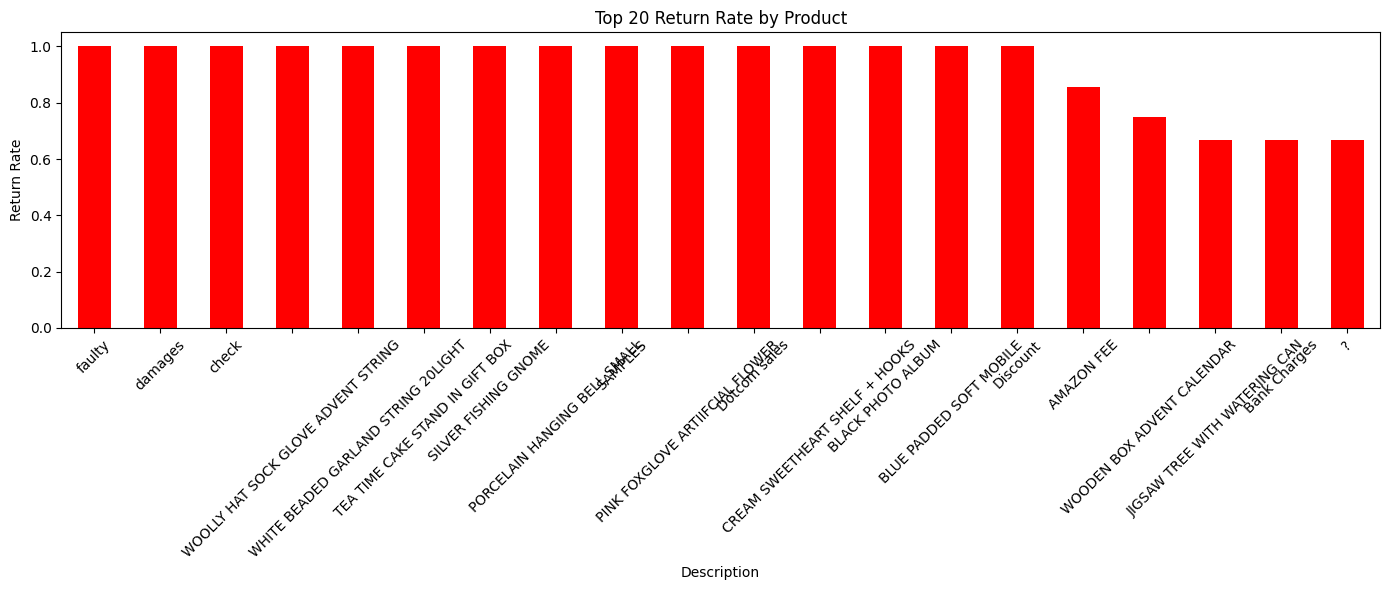

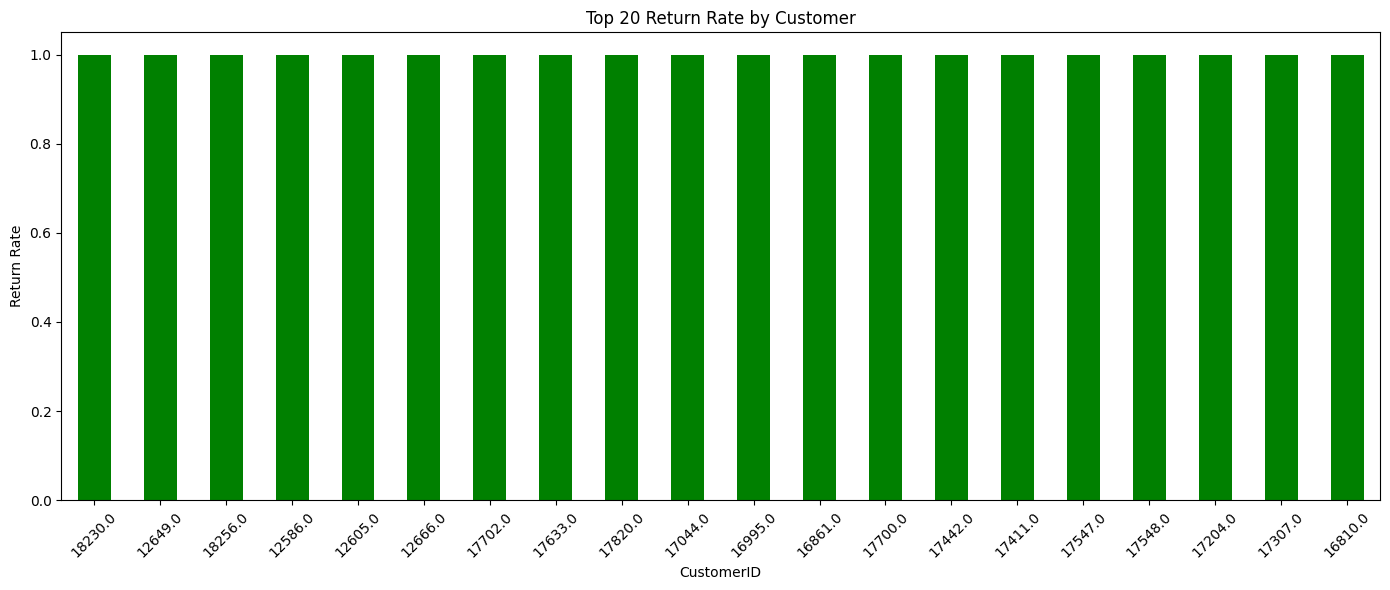

In [24]:
# Calculate return rate by country, product, and customer
return_rate_country = df.groupby('Country')['IsReturned'].mean().sort_values(ascending=False)
return_rate_product = df.groupby('Description')['IsReturned'].mean().sort_values(ascending=False)
return_rate_customer = df.groupby('CustomerID')['IsReturned'].mean().sort_values(ascending=False)

# Plot: Return rate by country
plt.figure(figsize=(12, 5))
return_rate_country.plot(kind='bar', title='Return Rate by Country', color='orange')
plt.ylabel('Return Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Return rate by product
plt.figure(figsize=(14, 6))
return_rate_product.head(20).plot(kind='bar', title='Top 20 Return Rate by Product', color='red')
plt.ylabel('Return Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Return rate by customer (top 20)
plt.figure(figsize=(14, 6))
return_rate_customer.head(20).plot(kind='bar', title='Top 20 Return Rate by Customer', color='green')
plt.ylabel('Return Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Overall Insight on Returns

By analyzing return rates across countries, products, and customers, we identify key problem areas for the business. Certain countries exhibit higher return tendencies, possibly due to policy or logistical factors. Specific products have extremely high return rates, signaling quality or shipping issues. Moreover, a subset of customers consistently returns their purchases, which may indicate either dissatisfaction or suspicious behavior. These insights help the company take targeted actions—such as improving product quality, tightening return policies, or enhancing customer support—to reduce return-related losses.


## Final Discussion and Recommendations

This exploratory data analysis provided valuable insights into the purchasing behavior of customers and the factors that influence revenue generation for the company. By investigating complex business questions using visualizations, group-based aggregations, and correlation analysis, we were able to uncover patterns that can directly inform business decisions.

One of the key findings is the strong relationship between the quantity of products sold and total revenue, which highlights the importance of encouraging bulk purchases through targeted promotions or volume discounts. Interestingly, higher unit prices did not correlate with higher revenue, suggesting that lower-priced items are driving overall performance — potentially due to higher sales volumes.

In addition, the analysis of purchasing activity by hour and country revealed peak times that vary across markets. These findings could be used to tailor advertising or promotional campaigns by time zone or region, maximizing customer engagement during local peak hours.

The correlation matrix helped identify strong associations between numerical variables, and the grouping by country and customer helped us rank revenue-driving markets and loyal customers. This type of segmentation is crucial for personalized marketing strategies.

While the analysis provided many useful insights, it's important to note limitations such as the lack of demographic data and potential seasonal effects that were not fully captured in this dataset. Also, return transactions and stock inconsistencies may have impacted the clarity of revenue patterns.

###  Recommendations:

- **Run targeted marketing campaigns during peak hours for each country.**
- **Offer volume-based incentives for popular product categories.**
- **Prioritize stock and inventory for best-performing countries and customer segments.**
- **Further enhance the dataset with customer demographics and seasonal indicators.**
- **In future work, consider predictive models to forecast demand more accurately.**

